# Mapas SITREP Locales

In [19]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from textwrap import wrap
from matplotlib.colors import LinearSegmentedColormap
import adjustText as aT
import pickle
import time

In [20]:
t = time.localtime()
timestamp = time.strftime('%b-%d-%Y_%H%M', t)

In [21]:
## definimos variables para el calculo mensual
mes_curso = 'AI2022-03.xlsx'
mes = '2022-03'

In [22]:
ruta_dpa_canton_ecuador = "shapefiles/dpa_canton_codificado_v1_4326.shp"
ruta_dpa_provincia_ecuador = "shapefiles/dpa_provincia_codificado4326.shp"

In [23]:
df_activity_info = pd.read_excel(r'C:\Users\jorcabrera\OneDrive - International Organization for Migration - IOM\InteragencyGTRM\GTRM 2022\IM 2022\ActivityInfo\DescargasMensuales\procesados\proc_'+mes_curso, index_col=0)

In [24]:
dpa_ecuador_cantones = gpd.read_file(ruta_dpa_canton_ecuador, encoding='utf-8')
dpa_ecuador_provincias = gpd.read_file(ruta_dpa_provincia_ecuador, encoding='utf-8')

In [25]:
ruta_salida = r'C:\Users\jorcabrera\OneDrive - International Organization for Migration - IOM\InteragencyGTRM\GTRM 2022\IM 2022\Mapas\SitrepLocales'

In [26]:
# Diccionario de colores para el mapa reclasificado
paletaActividades = {'Sin Actividades': 'white','1 - 10': 'lightcyan','11 - 100': 'paleturquoise','más de 100': 'teal','Nulo': 'black','Error': 'black'}

In [27]:
def fixCodigoCantonalFromNumber(row, source_col, output_col):
    """
    Aumenta el cero a los codigos cantonales importados como numero desde excel
    """
    if len(str(row[source_col])) == 3:
        row[output_col] = '0' + str(row[source_col])
    else:
        row[output_col] = str(row[source_col])
    return row

In [28]:
def clasificadorActividades(row, source_col, output_col):
    """
    Sirve para reclasificar las actividades segun su cantidad y
    facilitar la elaboracion de productos cartograficos con coropletas
    Params:
    row = registro de dataframe, no se tipea al usarse
    source_col = nombre de la columna que tiene los datos de fuente que seran cambiados
    output_col = nombre de la columna donde se almacenarán los datos nuevos
    return row = devuelve como resultado el registro armado con las variables anteriores
    en la forma row[output_col]
    """
    if row[source_col] == None:
        row[output_col] = 'Nulo'
    if row[source_col] < 1.0:
        row[output_col] = 'Sin Actividades'
    elif row[source_col] >= 1 and row[source_col] < 11.0:
        row[output_col] = '1 - 10'
    elif row[source_col] > 10.0 and row[source_col] < 101.0:
        row[output_col] = '11 - 100'
    elif row[source_col] > 100.0 and row[source_col] < 1000000000:
        row[output_col] = 'más de 100'
    else:
        row[output_col] = 'Error'
    return row

In [29]:
def crea_mapa_GTRM_Local(provincia_dataframe, gtrm_geodataframe, nombre_GTRM, map_attribute, color_dict, mes,
                         output_path):
    fontSize = 8
    gtrm_geodataframe = gtrm_geodataframe.copy()
    gtrm_geodataframe = gtrm_geodataframe.loc[gtrm_geodataframe['GTRM'] == nombre_GTRM]
    # Se calcula el bbox de los cantones de cada GTRM para  usar como area de interes
    bbox = gtrm_geodataframe.total_bounds
    p1 = Point(bbox[0], bbox[3])
    p2 = Point(bbox[2], bbox[3])
    p3 = Point(bbox[2], bbox[1])
    p4 = Point(bbox[0], bbox[1])
    np1 = (p1.coords.xy[0][0], p1.coords.xy[1][0])
    np2 = (p2.coords.xy[0][0], p2.coords.xy[1][0])
    np3 = (p3.coords.xy[0][0], p3.coords.xy[1][0])
    np4 = (p4.coords.xy[0][0], p4.coords.xy[1][0])
    bb_polygon = Polygon([np1, np2, np3, np4])
    # Se crea un buffer prqueño para que los límites no queden muy pegados
    df2 = gpd.GeoDataFrame(gpd.GeoSeries(bb_polygon), columns=['geometry']).buffer(0.02)
    # Se aplica buffer cero para evitar errores topologicos y geometricos en la operacion de corte
    provincias_clipped = gpd.clip(provincia_dataframe.buffer(0), df2.buffer(0))
    variable = map_attribute
    gtrm_geodataframe["center"] = gtrm_geodataframe["geometry"].representative_point()
    gtrm_geodataframe_pts = gtrm_geodataframe.copy()
    gtrm_geodataframe_pts.set_geometry("center", inplace=True)
    # La primera opcion fue usar mapas generales de coropletas
    # ax = gtrm_geodataframe.plot(figsize = (15, 12), column=variable, cmap=color_schema, edgecolor = "gray", linewidth = 0.5)
    ax = gtrm_geodataframe.plot(figsize=(15, 12))
    # Se asigna en el loop el color correspondiente segun los atributos y el diccionario de colores
    for ctype, data in gtrm_geodataframe.groupby(map_attribute):
        color = color_dict[ctype]
        data.plot(color=color,
                  ax=ax,
                  edgecolor="black",
                  linewidth=0.5, zorder=2)
    # provincias_clipped.plot(color='snow',linewidth = 0,ax=ax)
    provincias_clipped.geometry.boundary.plot(color='lightgray', linewidth=1, ax=ax, zorder=3)
    provincias_clipped.plot(color='ghostwhite', ax=ax, zorder=1)
    # ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
    texts = []
    for x, y, label in zip(gtrm_geodataframe_pts.geometry.x, gtrm_geodataframe_pts.geometry.y,
                           gtrm_geodataframe_pts["DPA_DESCAN"]):
        if len(label) > 9:
            label = '\n'.join(wrap(label, 12))
            label = plt.annotate(label, xy=(x, y), fontsize=fontSize, ha='center', va='top', wrap=True)
            label.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])
            texts.append(label)
        else:
            label = plt.annotate(label, xy=(x, y), fontsize=fontSize, ha='center', va='top', wrap=True)
            label.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])
            texts.append(label)
    aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1, 1), expand_text=(1, 1))
    ax.set_axis_off()
    fig = ax.get_figure()
    fig.savefig(output_path + "\\" + nombre_GTRM + "_" + mes + ".png")

In [30]:
# Variable que se usa para guardar los atributos a usar en la leyenda del mapa
actividades_reclasificadas_conteo = 'actividades_reclasificadas'

In [31]:
df_activity_info = df_activity_info[(df_activity_info['mes'] == '2022-01') | (df_activity_info['mes'] == '2022-02') | (df_activity_info['mes'] == '2022-03')]

In [32]:
pivot_canton=df_activity_info.groupby(['DPA_CANTON'])['Value'].agg('count').reset_index()

In [33]:
pivot_canton = pivot_canton.apply(fixCodigoCantonalFromNumber, source_col='DPA_CANTON', output_col='DPA_CANTON1', axis=1)
pivot_canton.drop(['DPA_CANTON'], axis=1, inplace=True)
pivot_canton.rename(columns = {'DPA_CANTON1':'DPA_CANTON'}, inplace = True)

In [34]:
dpa_ecuador_beneficiarios = pd.merge(dpa_ecuador_cantones, pivot_canton, how='left', on='DPA_CANTON')
dpa_ecuador_beneficiarios['Value'] = dpa_ecuador_beneficiarios['Value'].fillna(value = 0)
dpa_ecuador_beneficiarios = dpa_ecuador_beneficiarios.apply(clasificadorActividades, source_col='Value',
                                                                output_col=actividades_reclasificadas_conteo, axis=1)

In [35]:
map_list = list(filter(None, dpa_ecuador_beneficiarios.GTRM.unique()))

<ipython-input-29-3119ccb72488>:20: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  provincias_clipped = gpd.clip(provincia_dataframe.buffer(0), df2.buffer(0))
<ipython-input-29-3119ccb72488>:20: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  provincias_clipped = gpd.clip(provincia_dataframe.buffer(0), df2.buffer(0))
<ipython-input-29-3119ccb72488>:20: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  provincias_clipped = gpd.clip(provincia_dataframe.buffer(0), df2.buffer(0))
<

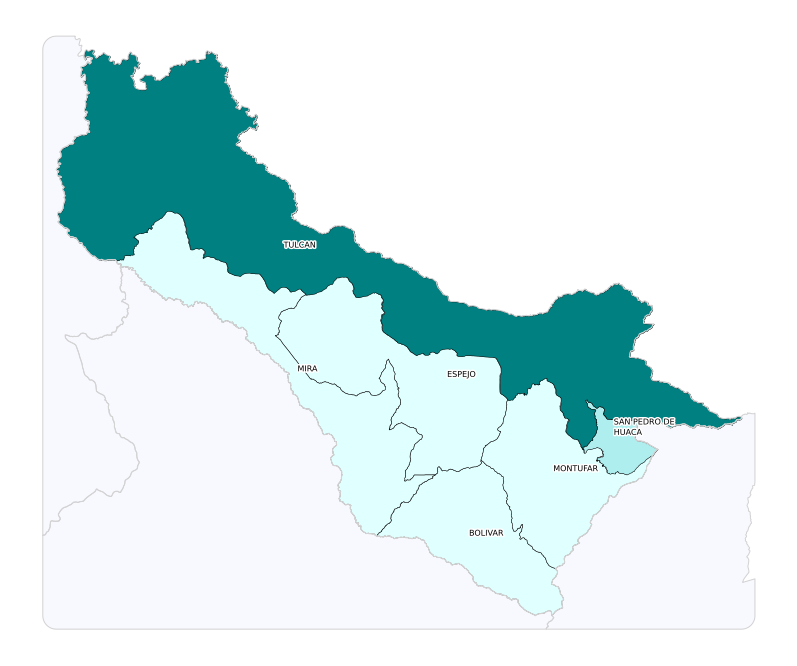

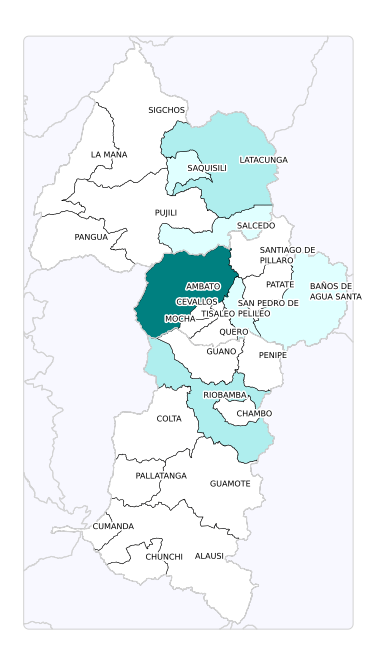

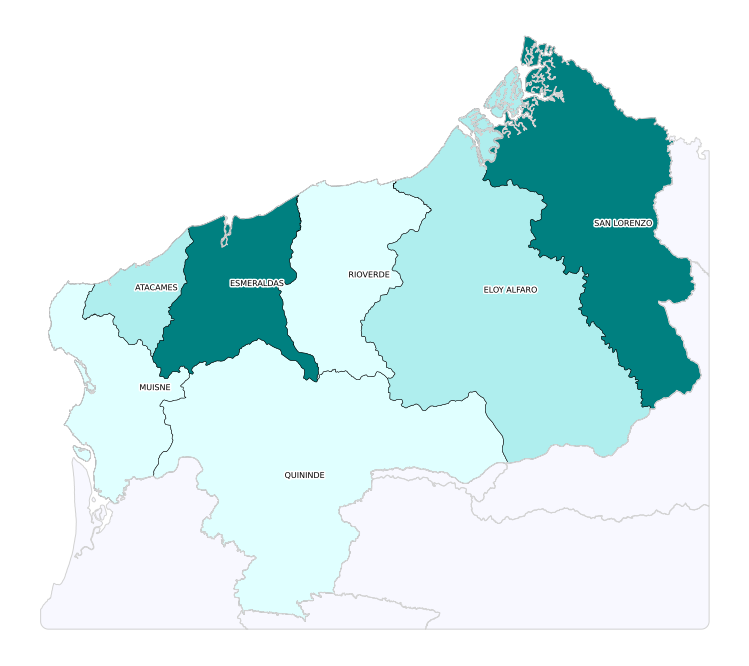

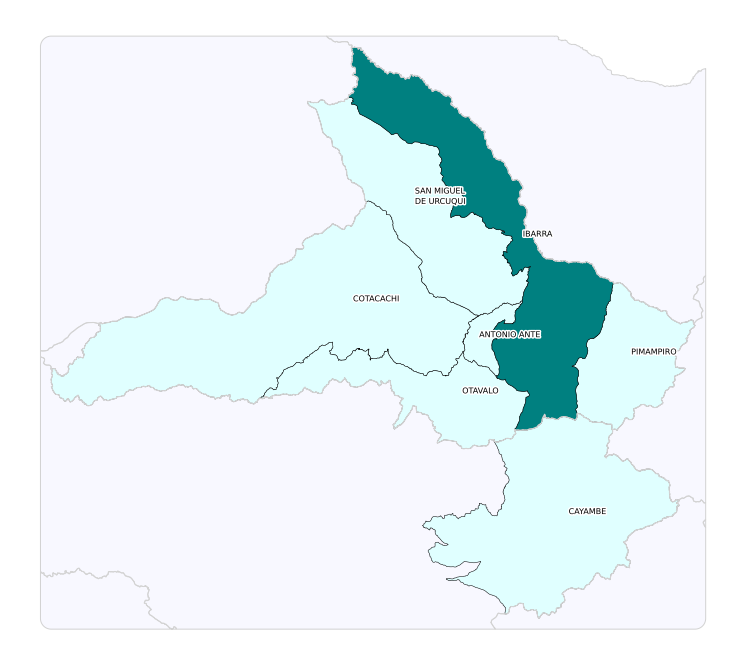

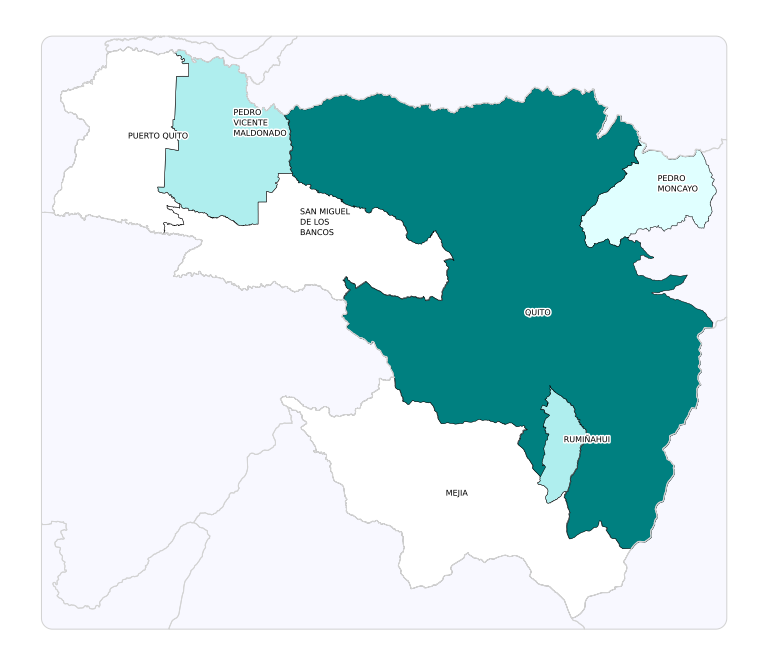

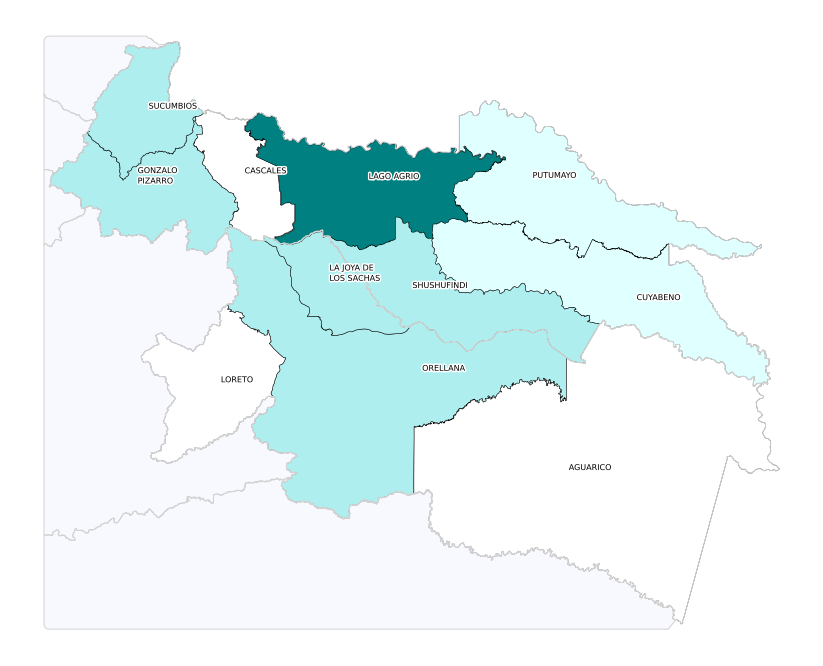

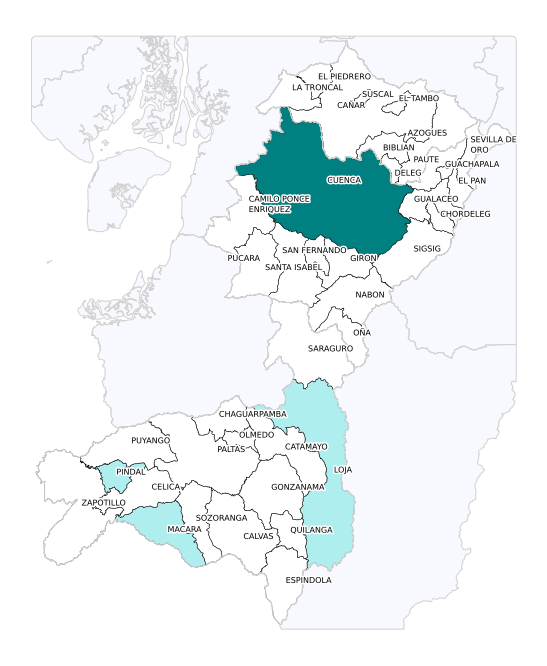

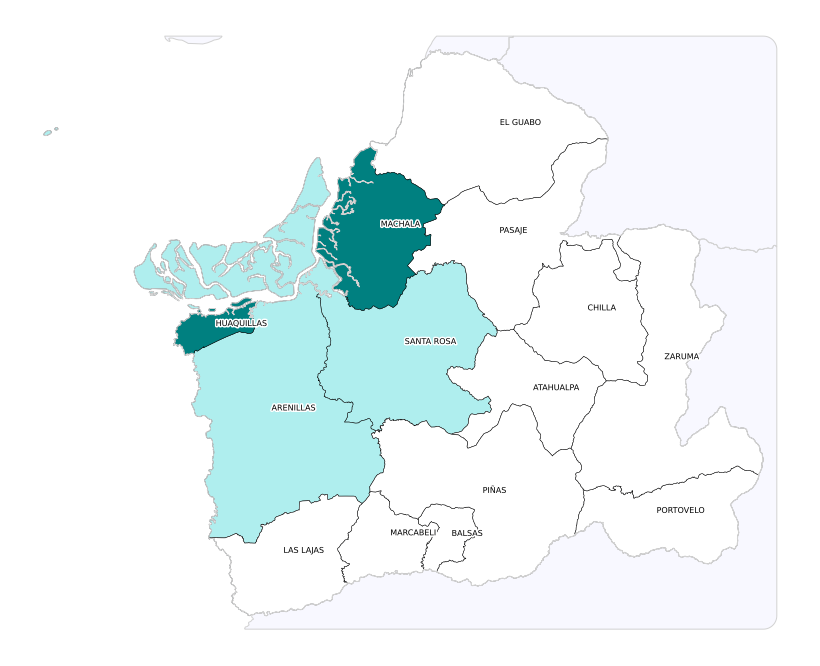

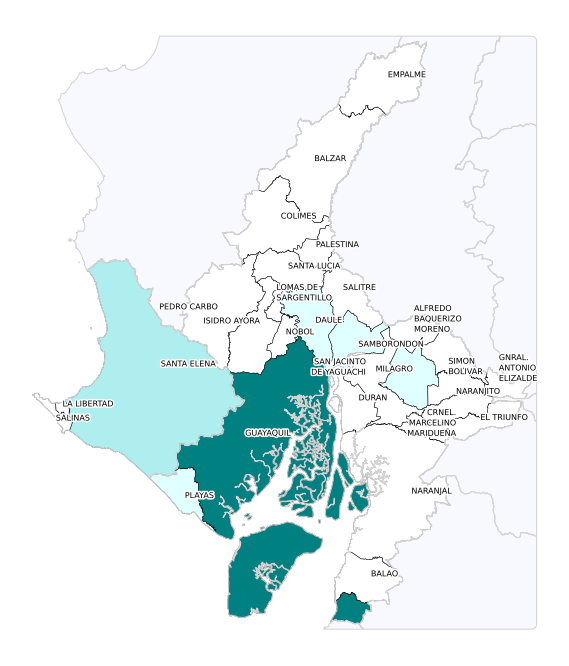

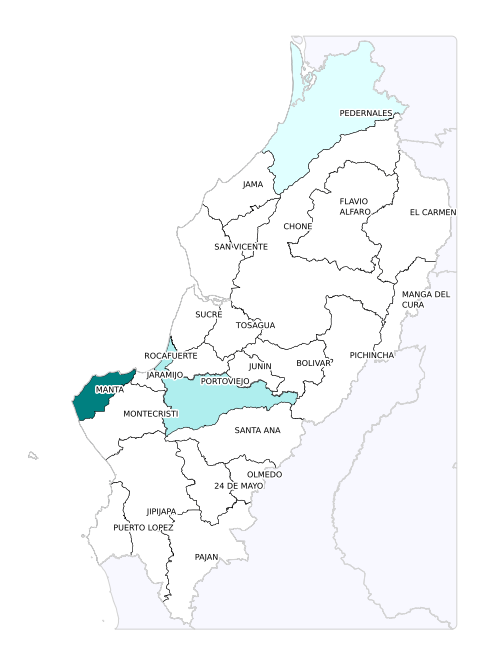

In [36]:
for mapa in map_list:
    if mapa is None:
        print('Error mapa es null')
        pass
    else:
        crea_mapa_GTRM_Local(dpa_ecuador_provincias, dpa_ecuador_beneficiarios, mapa,
                             actividades_reclasificadas_conteo, paletaActividades,
                             timestamp, ruta_salida)